### Guidance
This script will
- constrain MCM and GEOS-Chem mechanism
- constrain the customized GEOS-Chem mechanism 

Version updates:

20230323, Comparing to v5, we added the MCM VOCs into the GEOS-Chem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.linear_model import LinearRegression
import os
import seaborn as sns
from matplotlib.colors import ListedColormap
from pathlib import Path

 
# Changing the CWD
os.chdir('/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_helper')
from data_processing import *
from F0AM_reader_MASTER import *
from Plotting_helper import *

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def calculate_sum_selected_index(df, selected_indices):
    """
    Calculate the sum of the mean values and the combined standard deviation for selected indices.

    Args:
    df (pd.DataFrame): A DataFrame with 'Mean' and 'Std' columns.
    selected_indices (list): A list of indices to be included in the calculation.

    Returns:
    dict: A dictionary with keys 'Sum of Means' and 'Combined Std' and their corresponding values.
    """
    # Filter the DataFrame to include only the selected indices
    selected_df = df.loc[selected_indices]

    # Calculate the sum of the means
    sum_of_means = selected_df['Mean'].sum()

    # Calculate the combined standard deviation
    # The combined standard deviation is the square root of the sum of the squares of the standard deviations
    combined_std = np.sqrt((selected_df['Std']**2).sum())

    return {'Sum of Means': sum_of_means, 'Combined Std': combined_std}

def combine_others(df, top_n=6):
    # Sort the DataFrame
    df_sorted = df.sort_values(by='Mean', ascending=False)
    
    # Select top N and others
    top_df = df_sorted.head(top_n)
    others_df = df_sorted.iloc[top_n:]

    # Number of rest
    others_num = len(df)-top_n
    
    # Sum mean and std for others
    others_sum = others_df.sum()
    others_sum.name = f'Other {others_num} PNs'

    # Combine top N with others
    combined_df = top_df.append(others_sum, ignore_index=False)
    return combined_df

In [3]:
# diff calcualiton 
diff_set = 'median'
#diff_set = 'mean'
# setting for smk or bkg
get_smk, get_smk_dil, get_smk_conorm = True, False, False
#get_smk, get_smk_dil, get_smk_conorm = False, True, False
#get_smk, get_smk_dil, get_smk_conorm = False, False, True
# setting up postfic name
if get_smk:         postfix = 'smk'
if get_smk_dil:     postfix = 'smk_dil'
if get_smk_conorm:  postfix = 'smk_conorm'

#### Check for multiple compounds

Model bias in MCM + FUR for NO2: 5.4 ppb (Mean Absolute Difference), 31% (Mean Relative Difference)
Model bias in MCM + FUR for NO2: 0.3 ppb (Mean Absolute Difference), 17% (Mean Relative Difference)
Model bias in MCM + FUR for NO2: -0.2 ppb (Mean Absolute Difference), -19% (Mean Relative Difference)
Model bias in MCM + FUR for NO2: 0.3 ppb (Mean Absolute Difference), 16% (Mean Relative Difference)
Model bias in MCM + FUR for HNO3: 3.2 ppb (Mean Absolute Difference), 203% (Mean Relative Difference)
Model bias in MCM + FUR for HNO3: 0.6 ppb (Mean Absolute Difference), 451% (Mean Relative Difference)
Model bias in MCM + FUR for HNO3: 0.1 ppb (Mean Absolute Difference), 881% (Mean Relative Difference)
Model bias in GEOS-Chem (base) for PAN: 3.3 ppb (Mean Absolute Difference), 51% (Mean Relative Difference)
Model bias in MCM + GEOS-Chem VOCs for PAN: 2.9 ppb (Mean Absolute Difference), 45% (Mean Relative Difference)
Model bias in MCM + FUR for PAN: 3.4 ppb (Mean Absolute Difference), 53% (

'\nif get_smk == True:\n    fig.savefig(prefix + \'F0AM_mech_comp_TS_smk_combine_\' + postfix_save + \'.pdf\', format="pdf", bbox_inches=\'tight\') \nelif get_smk_dil == True:\n    fig.savefig(prefix + \'F0AM_mech_comp_TS_smk_dil_combine_\' + postfix_save + \'.pdf\', format="pdf", bbox_inches=\'tight\') \nelif get_smk_conorm == True:\n    fig.savefig(prefix + \'F0AM_mech_comp_TS_smk_conorm_combine_\' + postfix_save + \'.pdf\', format="pdf", bbox_inches=\'tight\') \n'

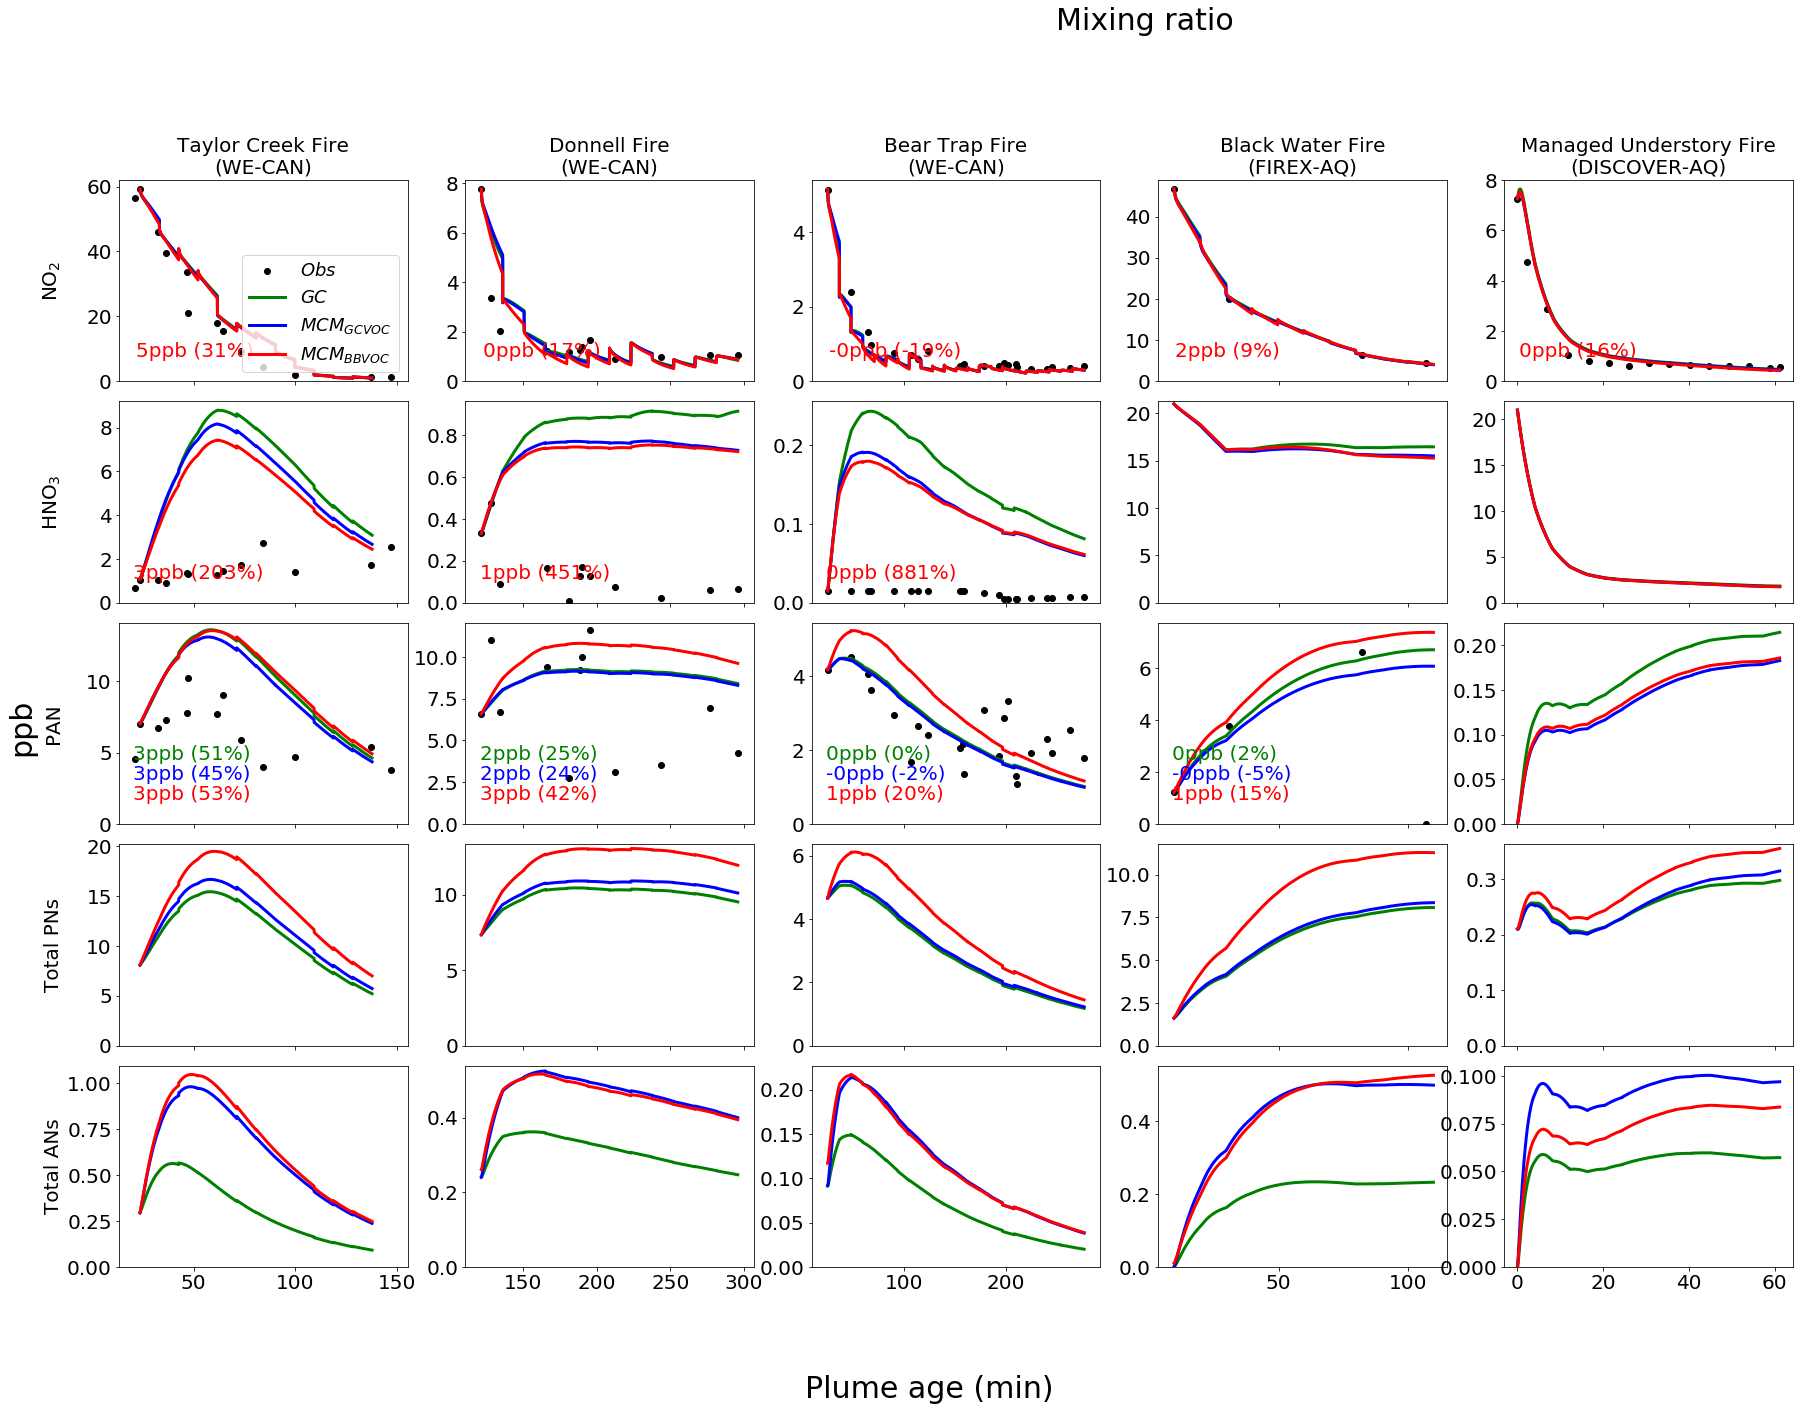

In [4]:
# ------------------------
# Set up needed  compounds 
# ------------------------
compounds = ['PAN', 'MPN', 'PPN']#, 'CH3O2']
compounds = ['PAN', 'PPN']#, 'CH3O2']
compounds = ['NO2', 'HNO3', 'PAN', 'TPNs', 'TANs']#, 'CH3O2']


#compounds = ['Glyoxal', 'Glycoaldehyde', 'Benzaldehyde', 'Butanedione']
#compounds = ['Glyoxal', 'Glycoaldehyde', 'Butanedione']
#compounds = ['HO2', 'TRO2']#, 'CH3O2']
#compounds = ['HONO', 'NOx','NO', 'NO2', 'NONO2Ratio']#, 'CH3O2']
#compounds = ['Formaldehyde', 'Acetaldehyde']
# HNO3 is only measured in WE-CAN
# PAN is measured in WE-CAN and FIREX-AQ

# Read compounds and each flight dataframe
Flight_IDs   = ['RF03', 'RF07', 'RF09', 'FN19', 'P-3B']
#Flight_IDs   = ['RF03', 'RF07', 'RF09']
# -----------------------
# plotting for the figure
# -----------------------
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label  = 18
fontsize_comp   = 20# this is for y label

# colors for model
colors = ['green', 'purple', 'orange', \
          'red', 'blue']
# subplots 
fig, axes = plt.subplots(len(compounds), len(Flight_IDs), 
                         figsize=(6*len(Flight_IDs), 4*len(compounds)),
                         sharex='col')
for row, compound in enumerate(compounds):
    for col, Flight_ID in enumerate(Flight_IDs):
        shaded_uncertainty = name2uncertainty.get(compound, 0)
        
        # ------------
        # Reading data
        # ------------
        # auto change for each flight ID
        if Flight_ID in ['RF03', 'RF07', 'RF09']: file_prefix  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['FN19']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
        if Flight_ID in ['P-3B']: file_prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
        file_obs = file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_obs_' + postfix +'.csv'
        path = Path(file_obs)
        
        # read in data
        if path.is_file():
            df_compound_obs = pd.read_csv(file_obs, index_col=0)
            df_compound_obs.index.name='Avg_physical_age_min'
        else:
            df_dummy = pd.read_csv(file_prefix + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
            df_compound_obs = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
            
        # remove the outliner for WE-CAN RF03
        #if Flight_ID == 'RF03': df_compound_obs = df_compound_obs.iloc[df_compound_obs.index != 124.7217351]
        #if Flight_ID == 'RF07': df_compound_obs = df_compound_obs.iloc[df_compound_obs.index != 157.768991]

        # reading model
        df_compound_mod = pd.read_csv(file_prefix + compound.replace(' ', '_') + '/'+ Flight_ID + '_mod_' + postfix +'.csv', index_col=0)
        df_compound_mod.index.name='Avg_physical_age_min'
       
        
        # --------
        # Plotting
        # --------
        if path.is_file() and df_compound_obs['Observation'].values[0] != 0:
            # polinomial regression line
            # train the model based on observation data
            idx = np.isfinite(df_compound_obs.index) & np.isfinite(df_compound_obs['Observation'])         # only pass datapoint with values
            coefs = np.polyfit(df_compound_obs.index[idx], df_compound_obs['Observation'][idx], 2)
            poly_model = np.poly1d(coefs)
            
            # plotting the scatter
            axes[row, col].scatter(df_compound_obs.index, df_compound_obs['Observation'], label = '$Obs$', color = 'black')
            # plotting the line of best fit
            #axes[row, col].plot(df_compound_mod.index, poly_model(df_compound_mod.index), \
            #                    color='black', label = '$Obs, fitted$', linewidth=linewidth)
            #axes[row, col].fill_between(df_compound_mod.index, poly_model(df_compound_mod.index)*(1-shaded_uncertainty), poly_model(df_compound_mod.index)*(1+shaded_uncertainty), color='black',
            #                     alpha=0.2)
            #axes[row, col].errorbar(df_compound_obs.index, df_compound_obs['Observation'], 
            #                yerr=shaded_uncertainty*df_compound_obs['Observation'], color='black', label='$Obs$', 
            #                linewidth=linewidth, linestyle='', capsize=5,marker='o')
        # edit part    
        if compound in ['OH', 'HO2', 'HOx', 'TRO2']: df_compound_mod = df_compound_mod*2.46*1e10
        
        # MCM
        axes[row, col].plot(df_compound_mod.index, df_compound_mod['GEOS-Chem (base)'],\
                            color=colors[0],  label='$GC$', linewidth=linewidth)
        axes[row, col].plot(df_compound_mod.index, df_compound_mod['MCM + GEOS-Chem VOCs'], \
                            color=colors[4],  label='$MCM_{GCVOC}$', linewidth=linewidth)  
        axes[row, col].plot(df_compound_mod.index, df_compound_mod['MCM + FUR'], \
                            color=colors[3],  label='$MCM_{BBVOC}$', linewidth=linewidth) 
        
        # ------------
        # Plot setting
        # ------------
        # set up the row
        if row == 0:
            axes[row, col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)
            
            
        # Set the y-axis to start from 0
        axes[row, col].set_ylim(bottom=0)  # This will ensure the y-axis starts at 0
            
        # y label 
        if col == 0: axes[row, col].set_ylabel(text_ysublabels[compound], size=fontsize_comp)
                
        # Spacing Out
        plt.subplots_adjust(wspace=.20, hspace=.10)
        axes[row, col].tick_params(axis='both', labelsize=fontsize_tick)
        
        # Display labels in the figure
        if (row, col) == (0, 0):
            font = font_manager.FontProperties(size=fontsize_label, weight='semibold')
            # edit part
            handles, labels= reorderLegend(axes[row, col],['$Obs$', \
                                                           #'$Obs, fitted$', \
                                                           '$GC$', '$MCM_{GCVOC}$', '$MCM_{BBVOC}$'])
            axes[row, col].legend(loc="lower right", prop=font, handles= handles, labels=labels)

        # edit part, uncomment when we compare MCM+Furan and MCM, with CTM VOCs
        # get the range for the x/y axis
        xmin, xmax = axes[row, col].get_xlim()
        ymin, ymax = axes[row, col].get_ylim()
    
        # Model evaluations
        if path.is_file() and df_compound_obs['Observation'].values[0] != 0:
            abs_diff_gc, relative_diff_gc = evaluate_model_differences(df_compound_obs, df_compound_mod['GEOS-Chem (base)'], poly_model, 'GEOS-Chem (base)', compound)
            abs_diff_mcm_gcvoc, relative_diff_mcm_gcvoc = evaluate_model_differences(df_compound_obs, df_compound_mod['MCM + GEOS-Chem VOCs'], poly_model, 'MCM + GEOS-Chem VOCs', compound)
            abs_diff_mcm_fur, relative_diff_mcm_fur = evaluate_model_differences(df_compound_obs, df_compound_mod['MCM + FUR'], poly_model, 'MCM + FUR', compound)

            diff_str_gc        = '{:.0f}'.format(abs_diff_gc) + 'ppb (' + '{:.0f}'.format(relative_diff_gc) +'%)'
            diff_str_mcm_gcvoc = '{:.0f}'.format(abs_diff_mcm_gcvoc) + 'ppb (' + '{:.0f}'.format(relative_diff_mcm_gcvoc) +'%)'
            diff_mcm_fur       = '{:.0f}'.format(abs_diff_mcm_fur) + 'ppb (' + '{:.0f}'.format(relative_diff_mcm_fur) +'%)'
            if compound in Comps_in_GC:
                axes[row, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str_gc, fontsize=fontsize_tick, color = colors[0])  
                axes[row, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str_mcm_gcvoc, fontsize=fontsize_tick, color = colors[4])  
            axes[row, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_mcm_fur, fontsize=fontsize_tick, color = colors[3])
        
            
        # Compare MCM with GEOS-Chem VOCs to GEOS-Chem (base)
        abs_diff_mcm_gc, relative_diff_mcm_gc = model_vs_model_evaluation(
            df_compound_mod['MCM + GEOS-Chem VOCs'],
            df_compound_mod['GEOS-Chem (base)'],
            'MCM + GEOS-Chem VOCs',
            'GEOS-Chem (base)',
            compound
        )

        # Compare MCM with FUR to GEOS-Chem (base)
        abs_diff_mcm_fur_gc, relative_diff_mcm_fur_gc = model_vs_model_evaluation(
            df_compound_mod['MCM + FUR'],
            df_compound_mod['GEOS-Chem (base)'],
            'MCM + FUR',
            'GEOS-Chem (base)',
            compound
        )

        # Optionally, you could also compare MCM with FUR to MCM with GEOS-Chem VOCs
        abs_diff_mcm_fur_gcvoc, relative_diff_mcm_fur_gcvoc = model_vs_model_evaluation(
            df_compound_mod['MCM + FUR'],
            df_compound_mod['MCM + GEOS-Chem VOCs'],
            'MCM + FUR',
            'MCM + GEOS-Chem VOCs',
            compound
        )

#  Align the first column of axes:
fig.align_ylabels(axes[:,0])

# Texts
unit='Molecule cm$^{-3}$' if compound in ['OH', 'HO2', 'HOx', 'TRO2'] else 'ppb'
if compound in ['NONO2Ratio']: unit = ''

if len(Flight_IDs) == 3: 
    fig.text(0.06,0.5, unit, ha="center", va="center", rotation=90, fontsize=30)
    fig.text(0.5,0.05, 'Plume age (min)', ha="center", va="bottom", fontsize=30)
    if get_smk:            fig.text(0.6,0.98, 'Mixing ratio', ha="center", va="top", fontsize=30)
    if get_smk_dil:        fig.text(0.52,0.98, 'Dilution-corrected mixing ratio', ha="center", va="top", fontsize=30)
    if get_smk_conorm:     fig.text(0.5,0.98, 'CO normalized value', ha="center", va="top", fontsize=30)

if len(Flight_IDs) == 4: 
    fig.text(0.06,0.5, unit, ha="center", va="center", rotation=90, fontsize=30)
    fig.text(0.5,0.07, 'Plume age (min)', ha="center", va="bottom", fontsize=30)
    if get_smk:            fig.text(0.6,1.0, 'Mixing ratio', ha="center", va="top", fontsize=30)
    if get_smk_dil:        fig.text(0.52,1.0, 'Dilution-corrected mixing ratio', ha="center", va="top", fontsize=30)
    if get_smk_conorm:     fig.text(0.5,1.0, 'CO normalized value', ha="center", va="top", fontsize=30)
    
if len(Flight_IDs) == 5: 
    fig.text(0.08,0.5, unit, ha="center", va="center", rotation=90, fontsize=30)
    fig.text(0.5,0.03, 'Plume age (min)', ha="center", va="bottom", fontsize=30)
    if get_smk:            fig.text(0.6,1.0, 'Mixing ratio', ha="center", va="top", fontsize=30)
    if get_smk_dil:        fig.text(0.52,1.0, 'Dilution-corrected mixing ratio', ha="center", va="top", fontsize=30)
    if get_smk_conorm:     fig.text(0.5,1.0, 'CO normalized value', ha="center", va="top", fontsize=30)
    
    
# Save the figure
prefix = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/output/'
if 'Ethane' in compounds: postfix_save = 'PrimaryVOCs'
if 'Formaldehyde' in compounds: postfix_save = 'MainOVOCs'
if 'Glyoxal' in compounds: postfix_save = 'SideOVOCs'
if 'NONO2Ratio' in compounds: postfix_save = 'MainReactiveN'
if 'Total NOy' in compounds: postfix_save = 'SideReactiveN'
if 'HOx' in compounds: postfix_save = 'Radicals'
'''
if get_smk == True:
    fig.savefig(prefix + 'F0AM_mech_comp_TS_smk_combine_' + postfix_save + '.pdf', format="pdf", bbox_inches='tight') 
elif get_smk_dil == True:
    fig.savefig(prefix + 'F0AM_mech_comp_TS_smk_dil_combine_' + postfix_save + '.pdf', format="pdf", bbox_inches='tight') 
elif get_smk_conorm == True:
    fig.savefig(prefix + 'F0AM_mech_comp_TS_smk_conorm_combine_' + postfix_save + '.pdf', format="pdf", bbox_inches='tight') 
'''

#### Check the contribution of each PNs

In [5]:
Flight_IDs   = ['P-3B', 'RF03', 'FN19']
Flight_IDs   = ['RF03', 'RF07', 'RF09']
interval_X = 30
# Define a continuous colormap
#cmap1 = sns.color_palette("light:r_r", as_cmap=True)
#cmap2 = sns.color_palette("light:b_r", as_cmap=True)
cmap1 = sns.light_palette("red", as_cmap=True)
cmap2 = sns.dark_palette("blue", as_cmap=True)


# Sample the colormap to get distinct colors
topX = 6
colors1 = [cmap1(i) for i in np.linspace(0, 1, topX+1)]  # Sample 10 distinct colors
colors2 = [cmap2(i) for i in np.linspace(0, 1, topX+1)]  # Sample 10 distinct colors
# Create a custom colormap from the list of colors
colors1 = ListedColormap(colors1)
colors2 = ListedColormap(colors2)
# plotting for the figure
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label  = 12
fontsize_comp   = 18

# colors for model
colors = ['green', 'purple', 'orange', \
          'red', 'blue']

compound = 'PNs'

# Initialize an empty DataFrame for combined production rates
combined_prod_rates_mcm_bbvoc      = {}
combined_prod_rates_mcm_bbvoc_total= {}
combined_prod_rates_mcm_bbvoc_freq = {}

combined_prod_rates_mcm_gcvoc      = {}
combined_prod_rates_mcm_gcvoc_total= {}
combined_prod_rates_mcm_gcvoc_freq = {}

combined_prod_rates_gc             = {}
combined_prod_rates_gc_total       = {}
combined_prod_rates_gc_freq        = {}

# subplots 
for col, Flight_ID in enumerate(Flight_IDs):
    shaded_uncertainty = name2uncertainty.get(compound, 0.15)
    # auto change for each flight ID
    if Flight_ID in ['RF03', 'RF07', 'RF09']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['FN19']: file_prefix_conc = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['P-3B']: file_prefix_conc = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
    file_obs = file_prefix_conc + compound.replace('PNs', 'TPNs') + '/'+ Flight_ID + '_obs_' + postfix +'.csv'
    path = Path(file_obs)
    file_prefix_rates = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'
    # ------------------------
    # Read concenctration data
    # ------------------------
    # Observation
    if path.is_file():
        df_compound_obs = pd.read_csv(file_obs, index_col=0)
        df_compound_obs.index.name='Avg_physical_age_min'
    else:
        df_dummy = pd.read_csv(file_prefix_conc + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
        df_compound_obs = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
    # Model
    df_compound_mod = pd.read_csv(file_prefix_conc + compound.replace('PNs', 'TPNs') + '/'+ Flight_ID + '_mod_' + postfix +'.csv', index_col=0)
    df_compound_mod.index.name='Avg_physical_age_min'
    # -------------------------
    # Read production/loss rate
    # -------------------------
    df_prod_mcm_bbvoc = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Production_rates_full_MCMBBVOC.csv', index_col=0)
    df_loss_mcm_bbvoc = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Loss_rates_full_MCMBBVOC.csv', index_col=0)

    df_prod_mcm_gcvoc = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Production_rates_full_MCMGCVOC.csv', index_col=0)
    df_loss_mcm_gcvoc = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Loss_rates_full_MCMGCVOC.csv', index_col=0)

    df_prod_gc        = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Production_rates_full_GC.csv', index_col=0)
    df_loss_gc        = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Loss_rates_full_GC.csv', index_col=0)

    # Replace the reactions with actual product
    df_prod_mcm_bbvoc = df_prod_mcm_bbvoc.rename(columns={
        'CH3CO3 + NO2': 'PAN',
        'CH3O2 + NO2': 'MPN',
        'ACO3 + NO2': 'ACRPAN',
        'HOCH2CO3 + NO2': 'PHAN',
        'C2H5CO3 + NO2': 'PPN',
        'MALDIALCO3 + NO2': 'MALDIALPAN',
    })    
    
    df_prod_mcm_gcvoc = df_prod_mcm_gcvoc.rename(columns={
        'CH3CO3 + NO2': 'PAN',
        'CH3O2 + NO2': 'MPN',
        'ACO3 + NO2': 'ACRPAN',
        'HOCH2CO3 + NO2': 'PHAN',
        'C2H5CO3 + NO2': 'PPN',
        'MALDIALCO3 + NO2': 'MALDIALPAN',
    })    

    df_prod_gc = df_prod_gc.rename(columns={
        'MCO3 + NO2 {+M}': 'PAN',
        'MO2 + NO2 {+M}': 'MPN',
        'RCO3 + NO2 {+M}': 'PPN',
        'MACR1OO + NO2': 'MPAN',
        'BZCO3 + NO2': 'BZPAN',
        'MACRNO2 + NO2': 'MPAN2',
    })    

    #df_prod['PPN'] = df_prod['C2H5CO3 + NO2'] + df_prod['C3H7CO3 + NO2'] + df_prod['C4H9CO3 + NO2'] + df_prod['C5H11CO3 + NO2']
    #df_prod.drop(['C2H5CO3 + NO2', 'C3H7CO3 + NO2', 'C4H9CO3 + NO2', 'C5H11CO3 + NO2'], axis=1, inplace=True)
    
    # Group time
    data_prod_mcm_bbvoc = bin_df(df_prod_mcm_bbvoc, interval_X)
    data_loss_mcm_bbvoc = bin_df(df_loss_mcm_bbvoc, interval_X)
    
    data_prod_mcm_gcvoc = bin_df(df_prod_mcm_gcvoc, interval_X)
    data_loss_mcm_gcvoc = bin_df(df_loss_mcm_gcvoc, interval_X)

    data_prod_gc = bin_df(df_prod_gc, interval_X)
    data_loss_gc = bin_df(df_loss_gc, interval_X)
    
    # group model data
    df_prod_mcm_bbvoc_dummy    = data_prod_mcm_bbvoc.xs('mean', level=1, axis=1) 
    df_prod_mcm_gcvoc_dummy    = data_prod_mcm_gcvoc.xs('mean', level=1, axis=1) 
    df_prod_gc_dummy           = data_prod_gc.xs('mean', level=1, axis=1) 
     
    df_prod_mcm_bbvoc_raw      = df_prod_mcm_bbvoc_dummy
    df_loss_mcm_bbvoc_raw      = data_loss_mcm_bbvoc.xs('mean', level=1, axis=1)    
    df_prod_mcm_bbvoc_raw_freq = (100)*df_prod_mcm_bbvoc_raw.div(df_prod_mcm_bbvoc_raw.sum(axis=1), axis=0)
    df_loss_mcm_bbvoc_raw_freq = (-100)*df_loss_mcm_bbvoc_raw.div(df_loss_mcm_bbvoc_raw.sum(axis=1), axis=0)

    df_prod_mcm_gcvoc_raw      = df_prod_mcm_gcvoc_dummy
    df_loss_mcm_gcvoc_raw      = data_loss_mcm_gcvoc.xs('mean', level=1, axis=1)    
    df_prod_mcm_gcvoc_raw_freq = (100)*df_prod_mcm_gcvoc_raw.div(df_prod_mcm_gcvoc_raw.sum(axis=1), axis=0)
    df_loss_mcm_gcvoc_raw_freq = (-100)*df_loss_mcm_gcvoc_raw.div(df_loss_mcm_gcvoc_raw.sum(axis=1), axis=0)

    df_prod_gc_raw      = df_prod_gc_dummy
    df_loss_gc_raw      = data_loss_gc.xs('mean', level=1, axis=1)    
    df_prod_gc_raw_freq = (100)*df_prod_gc_raw.div(df_prod_gc_raw.sum(axis=1), axis=0)
    df_loss_gc_raw_freq = (-100)*df_loss_gc_raw.div(df_loss_gc_raw.sum(axis=1), axis=0)
    
    # Save out the produciton
    # Drop the PAN, PPN, and MPN columns
    df_prod_mcm_bbvoc_raw_clean      = df_prod_mcm_bbvoc_raw.drop(columns=['PAN', 'PPN', 'MPN'])
    df_prod_mcm_gcvoc_raw_clean      = df_prod_mcm_gcvoc_raw.drop(columns=['PAN', 'PPN', 'MPN'])
    df_prod_gc_raw_clean             = df_prod_gc_raw.drop(columns=['PAN', 'PPN', 'MPN'])


    df_prod_mcm_bbvoc_raw_freq_clean = (100)*df_prod_mcm_bbvoc_raw_clean.div(df_prod_mcm_bbvoc_raw_clean.sum(axis=1), axis=0)
    df_prod_mcm_gcvoc_raw_freq_clean = (100)*df_prod_mcm_gcvoc_raw_clean.div(df_prod_mcm_gcvoc_raw_clean.sum(axis=1), axis=0)
    df_prod_gc_raw_freq_clean        = (100)*df_prod_gc_raw_clean.div(df_prod_gc_raw_clean.sum(axis=1), axis=0)

    combined_prod_rates_mcm_bbvoc[Flight_ID]      = df_prod_mcm_bbvoc_raw_clean.mean(axis=0)
    combined_prod_rates_mcm_bbvoc_total[Flight_ID]= df_prod_mcm_bbvoc_raw_clean.mean(axis=0).sum()
    combined_prod_rates_mcm_bbvoc_freq[Flight_ID] = df_prod_mcm_bbvoc_raw_freq_clean.mean(axis=0)

    combined_prod_rates_mcm_gcvoc[Flight_ID]      = df_prod_mcm_gcvoc_raw_clean.mean(axis=0)
    combined_prod_rates_mcm_gcvoc_total[Flight_ID]= df_prod_mcm_gcvoc_raw_clean.mean(axis=0).sum()
    combined_prod_rates_mcm_gcvoc_freq[Flight_ID] = df_prod_mcm_gcvoc_raw_freq_clean.mean(axis=0)

    combined_prod_rates_gc[Flight_ID]             = df_prod_gc_raw_clean.mean(axis=0)
    combined_prod_rates_gc_total[Flight_ID]       = df_prod_gc_raw_clean.mean(axis=0).sum()
    combined_prod_rates_gc_freq[Flight_ID]        = df_prod_gc_raw_freq_clean.mean(axis=0)

In [6]:
# Convert your dictionary to a DataFrame
df_rates_mcm_bbvoc = pd.DataFrame(combined_prod_rates_mcm_bbvoc)
df_freq_mcm_bbvoc  = pd.DataFrame(combined_prod_rates_mcm_bbvoc_freq)
df_rates_mcm_gcvoc = pd.DataFrame(combined_prod_rates_mcm_gcvoc)
df_freq_mcm_gcvoc  = pd.DataFrame(combined_prod_rates_mcm_gcvoc_freq)
df_rates_gc        = pd.DataFrame(combined_prod_rates_gc)
df_freq_gc         = pd.DataFrame(combined_prod_rates_gc_freq)

# Calculate mean and standard deviation for each reaction
mean_values_mcm_bbvoc = df_rates_mcm_bbvoc.mean(axis=1)
std_values_mcm_bbvoc  = df_rates_mcm_bbvoc.std(axis=1)
mean_values_mcm_gcvoc = df_rates_mcm_gcvoc.mean(axis=1)
std_values_mcm_gcvoc  = df_rates_mcm_gcvoc.std(axis=1)
mean_values_gc        = df_rates_gc.mean(axis=1)
std_values_gc         = df_rates_gc.std(axis=1)

mean_freq_mcm_bbvoc   = df_freq_mcm_bbvoc.mean(axis=1)
std_freq_mcm_bbvoc    = df_freq_mcm_bbvoc.std(axis=1)
mean_freq_mcm_gcvoc   = df_freq_mcm_gcvoc.mean(axis=1)
std_freq_mcm_gcvoc    = df_freq_mcm_gcvoc.std(axis=1)
mean_freq_gc          = df_freq_gc.mean(axis=1)
std_freq_gc           = df_freq_gc.std(axis=1)

# Combine mean and std into a single DataFrame
combined_stats_rates_mcm_bbvoc = pd.DataFrame({'Mean': mean_values_mcm_bbvoc, 'Std': std_values_mcm_bbvoc})
combined_stats_freq_mcm_bbvoc  = pd.DataFrame({'Mean': mean_freq_mcm_bbvoc, 'Std': std_freq_mcm_bbvoc})
combined_stats_rates_mcm_gcvoc = pd.DataFrame({'Mean': mean_values_mcm_gcvoc, 'Std': std_values_mcm_gcvoc})
combined_stats_freq_mcm_gcvoc  = pd.DataFrame({'Mean': mean_freq_mcm_gcvoc, 'Std': std_freq_mcm_gcvoc})
combined_stats_rates_gc        = pd.DataFrame({'Mean': mean_values_gc, 'Std': std_values_gc})
combined_stats_freq_gc         = pd.DataFrame({'Mean': mean_freq_gc, 'Std': std_freq_gc})

# Sort the DataFrame by the 'Mean' column in descending order
combined_stats_rates_mcm_bbvoc = combined_stats_rates_mcm_bbvoc.sort_values(by='Mean', ascending=False)
combined_stats_freq_mcm_bbvoc  = combined_stats_freq_mcm_bbvoc.sort_values(by='Mean', ascending=False)
combined_stats_rates_mcm_gcvoc = combined_stats_rates_mcm_gcvoc.sort_values(by='Mean', ascending=False)
combined_stats_freq_mcm_gcvoc  = combined_stats_freq_mcm_gcvoc.sort_values(by='Mean', ascending=False)
combined_stats_rates_gc        = combined_stats_rates_gc.sort_values(by='Mean', ascending=False)
combined_stats_freq_gc         = combined_stats_freq_gc.sort_values(by='Mean', ascending=False)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Applying the function
combined_rates_mcm_bbvoc = combine_others(combined_stats_rates_mcm_bbvoc, top_n  =6)
combined_freq_mcm_bbvoc  = combine_others(combined_stats_freq_mcm_bbvoc,  top_n = 6)

combined_rates_mcm_gcvoc = combine_others(combined_stats_rates_mcm_gcvoc, top_n = 4)
combined_freq_mcm_gcvoc  = combine_others(combined_stats_freq_mcm_gcvoc,  top_n = 4)

combined_rates_gc        = combine_others(combined_stats_rates_gc,        top_n = 4)
combined_freq_gc         = combine_others(combined_stats_freq_gc,         top_n = 4)

In [7]:
# Rename each index
combined_rates_mcm_bbvoc = combined_rates_mcm_bbvoc.rename(index={'ACRPAN'       : 'C3',
                                                                  'PHAN'         : 'C2',
                                                                  'MALDIALPAN'   : 'C4-1',
                                                                  'MACO3 + NO2'  : 'C4-2',
                                                                  'C4H9CO3 + NO2': 'C5',
                                                                  'C6H5CO3 + NO2': 'C6'
                                                                 })

In [27]:
import re
def count_carbons(name, abbreviation_mapping={}):
    # Remove '+ NO2', '+ NO' and spaces
    name_clean = name.replace('+ NO2', '').replace('+ NO', '').replace('+ HO2', '').replace('+ MO2', '').replace('+ INO2D', '').replace('+ INO2B', '').replace(' ', '')
    name_simple = name_clean.strip()
    
    # Check abbreviation mapping first
    if name_simple in abbreviation_mapping:
        carbon_count = abbreviation_mapping[name_simple]
    else:
        # Use regex to find all 'C's possibly followed by numbers
        matches = re.findall(r'C\d*', name_clean)
        carbon_count = 0
        for match in matches:
            number_part = match[1:]
            if number_part == '':
                carbon_count += 1
            else:
                carbon_count += int(number_part)
    
    # Categorize if carbon count is more than 8
    if carbon_count > 8:
        return "C9-C17"
    elif carbon_count == 0:
        return np.nan
    else:
        return carbon_count
abbreviation_mapping = {
    #MCM
    'ACRPAN'    : 3,
    'PHAN'      : 2,
    'MALDIALPAN': 4,
    'MACO3'     : 4,
    'C4H9CO3'   : 5,
    'C6H5CO3'   : 6,
    'C96CO3'    : 10,
    'C89CO3'    : 9, 
    'C14H21O4'  : 14,
    'C23O3MCO3' : 6, 
    'C4H3O5'    : 4,
    'C136CO3'   : 14,
    'C137CO3'   : 14,
    'C23O3MCO3' : 6,
    'H3C25C6CO3': 7, 
    'C811CO3'   : 9, 
    'C920CO3'   : 10,
    'C23O3CCO3' : 5,
    'C312COCO3 ': 4,
    'C512CO3'   : 6,  
    'C88CO3'    : 9,
    'C312COCO3' : 4,
    'C31CO3'    : 4,
    'C827CO3'   : 9,
    'C85CO3'    : 9,
    'C1011CO3'  : 11,
    'C141CO3'   : 15,
    'C41CO3'    : 5,
    'C46CO3'    : 5, 
    'HO2C43CO3' : 5, 
    'C522CO3'   : 6, 
    'C126CO3'   : 13,
    'C87CO3'    : 9,
    'C131CO3'   : 14,
    'C57NO3CO3' : 5,
    'C718CO3'   : 8, 
    'C116CO3'   : 12,
    'HPC52CO3'  : 5, 
    'C615CO3'   : 7, 
    'C139O2'    : 13,
    'C58NO3CO3' : 5, 
    'C1013CO3'  : 11,
    'C918CO3'   : 10, 
    'C88CO3'    : 9, 
    'C830CO3'   : 9, 
    'H1C23C4CO3': 5, 
    'C721CO3'   : 8,
    'C928CO3'   : 10, 
    'C617CO3'   : 7, 
    'C618CO3'   : 7, 
    'C1210CO3'  : 13, 
    'C1211CO3'  : 13, 
    'C515CO3'   : 6,
    'C47CO3'    : 5, 
    'C61CO3'    : 5, 
    'C65NO36CO3': 6, 
    'C62CO3'    : 7, 
    'C42CO3'    : 5,
    'C1212O2'   : 12, 
    'NC91CO3'  : 10, 
    'NC61CO3'  : 7,
    'C828CO3'  : 9, 
    'C5124COCO3' : 6, 
    'C67CO3' : 7, 
    'H13C43CO3' : 5,
    'HM2C43CO3' : 6, 
    'M2C43CO3'  : 6, 

    'OXYLCO3'   : 8,
    'IPRCO3'    : 4,
    'BUT2CO3'   : 5,
    'M3BU3ECO3' : 5,
    'CH3SO2O2'  : 2,
    'EPXMDLCO3' : 5,
    'EPXDLCO3'  : 4,
    'EPXKTMCO3' : 6, 
    'IBUDIALCO3': 4, 
    'HMACO3'    : 4, 
    'TM123BCO3' : 9, 
    'CH3SOO2'   : 2, 
    'EPXMKTCO3' : 6, 
    
    'TM135MUCO3': 9,
    
    'PXYLCO3'   : 8, 
    'EPXMEDLCO3': 7, 
    'EPXM2DLCO3': 7, 
    'TMBCO3'    : 9,
    'HOBUT2CO3' : 5,
    'INAHPCO3'  : 5, 
    'HOIPRCO3'  : 4, 
    'HM22CO3'   : 5,
    'INDHCO3'   : 5,
    'IEACO3'    : 5,
    'IPRHOCO3'  : 4,
    'MMALNACO3' : 5,
    'INDHPCO3'  : 5,
    'IEACO3'    : 5,
    'IPRHOCO3'  : 4,
    'MMALNACO3' : 5,
    'INDHPCO3'  : 5, 
    'INB1HPCO3' : 5, 
    'PRNO3CO3'  : 3, 
    'INB1NBCO3' : 5, 
    'INB1NACO3' : 5, 
    'MMALNBCO3' : 5, 
    'HOIBUTCO3' : 5, 
    'INANCO3'   : 5, 
    'INAHCO3'   : 5, 
    'TBUTCO3'   : 5, 
    'MPRBNO3CO3': 4, 
    'PROL1MCO3' : 5, 
    'HMVKBCO3'  : 5, 
    
    # GEOS-Chem
    'MPAN'      : 4,
    'BZPAN'     : 4,
    'MPAN2'     : 4, 
    'INO2D': 5, 
    'INO2B': 5,
}

In [122]:
# Create the dataframe with the original index and carbon counts
carbon_counts_mcm_bbvoc = [count_carbons(x, abbreviation_mapping) for x in combined_stats_rates_mcm_bbvoc.index]
carbon_counts_mcm_gcvoc = [count_carbons(x, abbreviation_mapping) for x in combined_stats_rates_mcm_gcvoc.index]
carbon_counts_gc        = [count_carbons(x, abbreviation_mapping) for x in combined_stats_rates_gc.index]

# Creating the dataframe
df_name2c_num_mcm_bbvoc = pd.DataFrame({
    'Compound': combined_stats_rates_mcm_bbvoc.index,
    'Carbon Count': carbon_counts_mcm_bbvoc
})
df_name2c_num_mcm_gcvoc = pd.DataFrame({
    'Compound': combined_stats_rates_mcm_gcvoc.index,
    'Carbon Count': carbon_counts_mcm_gcvoc
})
df_name2c_num_gc = pd.DataFrame({
    'Compound': combined_stats_rates_gc.index,
    'Carbon Count': carbon_counts_gc
})

# Reset the index of df_name2carbonnum
df_name2c_num_mcm_bbvoc = df_name2c_num_mcm_bbvoc.reset_index()
df_name2c_num_mcm_gcvoc = df_name2c_num_mcm_gcvoc.reset_index()
df_name2c_num_gc        = df_name2c_num_gc.reset_index()

# Map Carbon Count using Compound names
combined_stats_rates_mcm_bbvoc['Carbon Count'] = combined_stats_rates_mcm_bbvoc.index.map(df_name2c_num_mcm_bbvoc.set_index('Compound')['Carbon Count'])
combined_stats_rates_mcm_gcvoc['Carbon Count'] = combined_stats_rates_mcm_gcvoc.index.map(df_name2c_num_mcm_gcvoc.set_index('Compound')['Carbon Count'])
combined_stats_rates_gc['Carbon Count']        = combined_stats_rates_gc.index.map(df_name2c_num_gc.set_index('Compound')['Carbon Count'])

combined_stats_freq_mcm_bbvoc['Carbon Count'] = combined_stats_freq_mcm_bbvoc.index.map(df_name2c_num_mcm_bbvoc.set_index('Compound')['Carbon Count'])
combined_stats_freq_mcm_gcvoc['Carbon Count'] = combined_stats_freq_mcm_gcvoc.index.map(df_name2c_num_mcm_gcvoc.set_index('Compound')['Carbon Count'])
combined_stats_freq_gc['Carbon Count']        = combined_stats_freq_gc.index.map(df_name2c_num_gc.set_index('Compound')['Carbon Count'])

# Group by Carbon Count and sum the values for Mean and Std
combined_stats_rates_mcm_bbvoc_grouped = combined_stats_rates_mcm_bbvoc.groupby('Carbon Count').sum()
combined_stats_rates_mcm_gcvoc_grouped = combined_stats_rates_mcm_gcvoc.groupby('Carbon Count').sum()
combined_stats_rates_gc_grouped        = combined_stats_rates_gc.groupby('Carbon Count').sum()

combined_stats_freq_mcm_bbvoc_grouped = combined_stats_freq_mcm_bbvoc.groupby('Carbon Count').sum()
combined_stats_freq_mcm_gcvoc_grouped = combined_stats_freq_mcm_gcvoc.groupby('Carbon Count').sum()
combined_stats_freq_gc_grouped        = combined_stats_freq_gc.groupby('Carbon Count').sum()


# Perform a join on the index, which is 'Carbon Count' in both DataFrames
combined_df_mcm_bbvoc_grouped = combined_stats_rates_mcm_bbvoc_grouped.join(combined_stats_freq_mcm_bbvoc_grouped, how='outer', lsuffix=' (rates)', rsuffix=' (freq)')
combined_df_mcm_gcvoc_grouped = combined_stats_rates_mcm_gcvoc_grouped.join(combined_stats_freq_mcm_gcvoc_grouped, how='outer', lsuffix=' (rates)', rsuffix=' (freq)')
combined_df_gc_grouped        = combined_stats_rates_gc_grouped.join(combined_stats_freq_gc_grouped, how='outer', lsuffix=' (rates)', rsuffix=' (freq)')

# Save out the data.
file_dir = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/OrganicNitrates/'
combined_df_mcm_bbvoc_grouped.to_csv(f'{file_dir}/combined_df_mcm_bbvoc_grouped.csv', index=True)
combined_df_mcm_gcvoc_grouped.to_csv(f'{file_dir}/combined_df_mcm_gcvoc_grouped.csv', index=True)
combined_df_gc_grouped.to_csv(f'{file_dir}/combined_df_gc_grouped.csv', index=True)

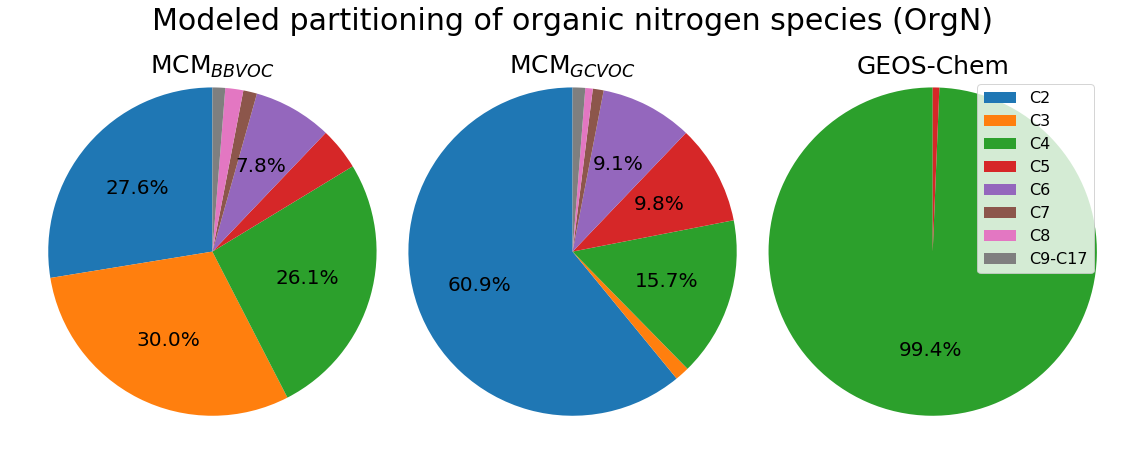

In [145]:
import matplotlib.pyplot as plt

# Assuming combined_df_mcm_bbvoc_grouped, combined_df_mcm_gcvoc_grouped, and combined_df_gc_grouped are already defined
common_index = ['C' + str(item) if isinstance(item, int) else item for item in combined_df_mcm_bbvoc_grouped.index]
combined_df_gc_grouped              = combined_df_gc_grouped.reindex(combined_df_mcm_bbvoc_grouped.index)
combined_df_gc_grouped.fillna(0, inplace=True)
combined_df_mcm_bbvoc_grouped.index = common_index
combined_df_mcm_gcvoc_grouped.index = common_index
combined_df_gc_grouped.index        = common_index

models = [combined_df_mcm_bbvoc_grouped, combined_df_mcm_gcvoc_grouped, combined_df_gc_grouped]
titles = ['MCM$_{BBVOC}$', 'MCM$_{GCVOC}$', 'GEOS-Chem']

# Create pie plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1x3 plot grid for three models

# Define custom autopct function with increased fontsize
def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 5 else ''

# Storing wedges for the legend
wedges_list = []

for i, model in enumerate(models):
    wedges, texts, autotexts = axs[i].pie(model['Mean (freq)'],
                                          autopct=lambda pct: custom_autopct(pct),
                                          startangle=90,
                                          textprops={'fontsize': 20})  # Set the fontsize for percentage labels
    axs[i].set_title(titles[i], fontsize=25, y=0.92)
    wedges_list.append(wedges)  # Store wedges for later legend use


plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=-0.35)

# Using a single legend for all pie charts, from wedges of the first model
fig.legend(wedges_list[0], common_index,
            loc="center right", bbox_to_anchor=(0.85, 0.66), fontsize=16, title_fontsize=16)
fig.text(0.5, 1, 'Modeled partitioning of organic nitrogen species (OrgN)', va='bottom', ha='center', fontsize=30)

plt.show()

# -------------
# Save out data
# -------------
# Save the DataFrames to CSV files
file_dir = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/VOC_OH_exposure/input'
combined_df_mcm_bbvoc_grouped.to_csv(f'{file_dir}/combined_df_mcm_bbvoc_grouped.csv')
combined_df_mcm_gcvoc_grouped.to_csv(f'{file_dir}/combined_df_mcm_gcvoc_grouped.csv')
combined_df_gc_grouped.to_csv(f'{file_dir}/combined_df_gc_grouped.csv')

27.566429636738192
29.98769908351194
26.134333484938125
4.181173761372451
7.749663809414308
1.3517151328344248
1.769122195180325
1.2542976209193355


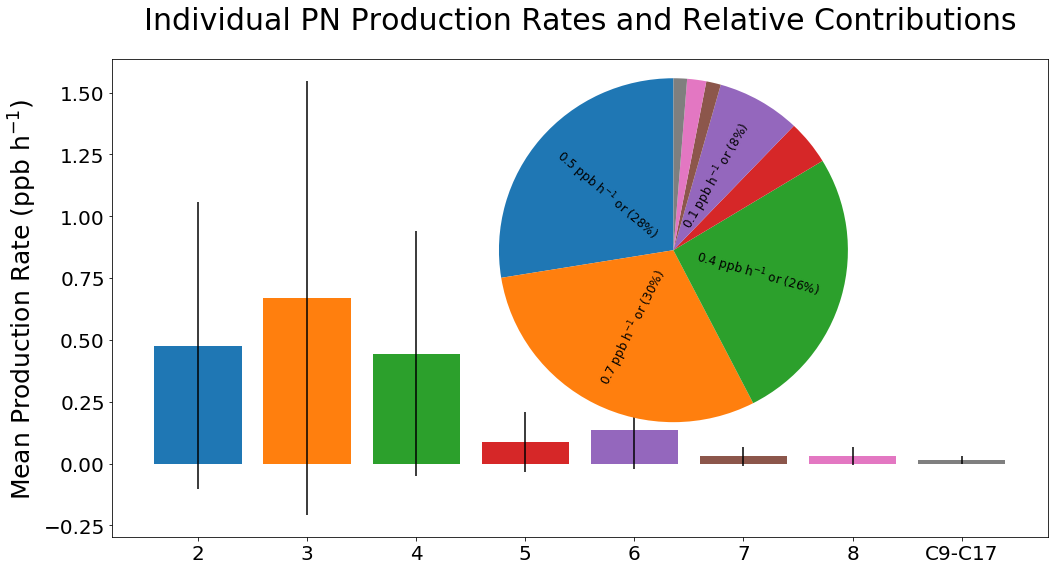

In [34]:
# -----------
# MCM BBVOCs
# -----------
# Create a color palette
colors = plt.cm.tab10.colors[:len(combined_df_mcm_bbvoc_grouped)]
palette = ListedColormap(colors)

# Create the bar plot
plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

# Convert categorical indices to numeric positions
categories = combined_df_mcm_bbvoc_grouped.index
x_positions = np.arange(len(categories))

# Bar plot
bar =  ax.bar(x_positions, combined_df_mcm_bbvoc_grouped['Mean (rates)'], yerr=combined_df_mcm_bbvoc_grouped['Std (rates)'], color=palette.colors)
# Set title with increased font size
ax.set_title('OrgN Production Rates and Relative Contributions (MCM BBVOC)', fontsize=30)
# Set x-ticks and labels with increased font size
ax.set_xticks(range(len(combined_df_mcm_bbvoc_grouped.index)))
ax.set_xticklabels(combined_df_mcm_bbvoc_grouped.index)
# Set x and y axis labels with increased font size
#ax.set_xlabel('Reaction', fontsize=14)
ax.set_ylabel('Mean Production Rate (ppb h$^{-1}$)', fontsize=25)
# Optionally, increase the font size of y-tick labels as well
ax.tick_params(axis='both', labelsize=20)

# Disable the grid for the bar plot
ax.grid(False)

# Pie chart parameters
radius = 0.9
pie_ax = ax.inset_axes([0.15, 0.15, radius, radius])  # Adjust position and size

# Create custom labels based on a threshold
labels = []
for comp, percent in zip(combined_df_mcm_bbvoc_grouped.index, combined_df_mcm_bbvoc_grouped['Mean (freq)']):
    if percent >= 5:  # Custom threshold
        labels.append(f"{combined_df_mcm_bbvoc_grouped.at[comp, 'Mean (rates)']:.1f} ppb h$^{{-1}}$ or ({percent:.0f}%)")
    else:
        labels.append(None)  # Hide label for small components

# Create the pie chart
pie_slices, _ = pie_ax.pie(combined_df_mcm_bbvoc_grouped['Mean (freq)'], 
                           autopct=None, startangle=90, labels=None)

# Calculate label positions and rotation within each slice
radius = 0.5
for wedge, label_text, comp in zip(pie_slices, labels, combined_df_mcm_bbvoc_grouped.index):
    angle = (wedge.theta1 + wedge.theta2) / 2.0
    x = radius * np.cos(np.deg2rad(angle))
    y = radius * np.sin(np.deg2rad(angle))
    
    # Adjust the rotation angle for the label
    rotation_angle = np.degrees(np.arctan2(y, x))
    # Correct the angle so that text is always right-side-up
    if angle > 90 and angle < 270:
        rotation_angle -= 180
    if comp == 'PAN':
        pie_ax.annotate(label_text, (x, y), 
                        ha='center', va='center', 
                        fontsize=15, rotation=rotation_angle)
    else:
        pie_ax.annotate(label_text, (x, y), ha='center', va='center', fontsize=12, rotation=rotation_angle)
        
# Customize the pie chart appearance
pie_ax.set_aspect('equal')  # Make it circular

# Show the plot
plt.tight_layout()
plt.show()

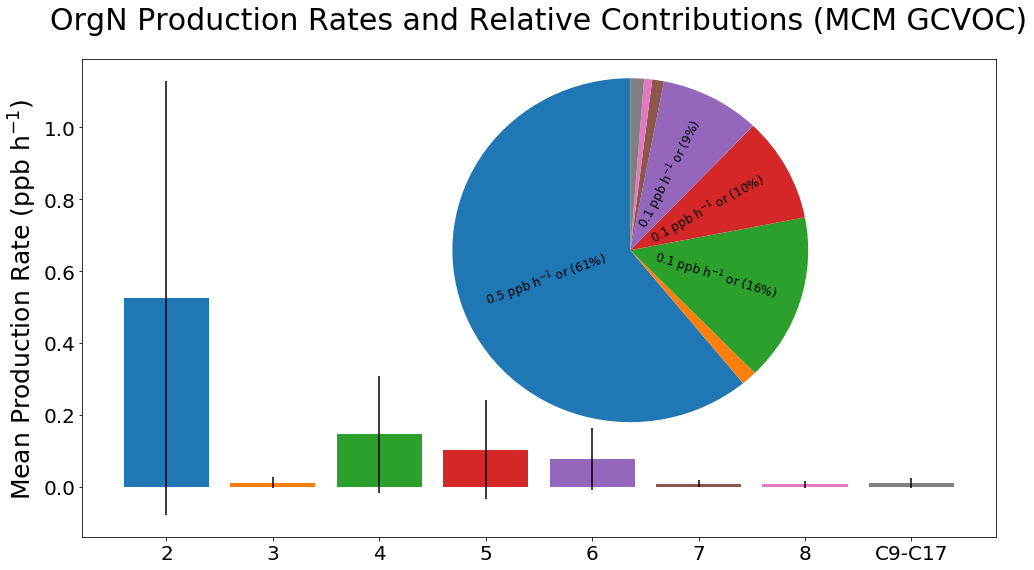

In [46]:
# -----------
# MCM GCVOCs
# -----------
# Create a color palette
colors = plt.cm.tab10.colors[:len(combined_df_mcm_gcvoc_grouped)]
palette = ListedColormap(colors)

# Create the bar plot
plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

# Convert categorical indices to numeric positions
categories = combined_df_mcm_gcvoc_grouped.index
x_positions = np.arange(len(categories))

# Bar plot
bar =  ax.bar(x_positions, combined_df_mcm_gcvoc_grouped['Mean (rates)'], yerr=combined_df_mcm_gcvoc_grouped['Std (rates)'], color=palette.colors)
# Set title with increased font size
ax.set_title('OrgN Production Rates and Relative Contributions (MCM GCVOC)', fontsize=30)
# Set x-ticks and labels with increased font size
ax.set_xticks(range(len(combined_df_mcm_gcvoc_grouped.index)))
ax.set_xticklabels(combined_df_mcm_gcvoc_grouped.index)
# Set x and y axis labels with increased font size
#ax.set_xlabel('Reaction', fontsize=14)
ax.set_ylabel('Mean Production Rate (ppb h$^{-1}$)', fontsize=25)
# Optionally, increase the font size of y-tick labels as well
ax.tick_params(axis='both', labelsize=20)

# Disable the grid for the bar plot
ax.grid(False)

# Pie chart parameters
radius = 0.9
pie_ax = ax.inset_axes([0.15, 0.15, radius, radius])  # Adjust position and size

# Create custom labels based on a threshold
labels = []
for comp, percent in zip(combined_df_mcm_gcvoc_grouped.index, combined_df_mcm_gcvoc_grouped['Mean (freq)']):
    if percent >= 5:  # Custom threshold
        labels.append(f"{combined_df_mcm_gcvoc_grouped.at[comp, 'Mean (rates)']:.1f} ppb h$^{{-1}}$ or ({percent:.0f}%)")
    else:
        labels.append(None)  # Hide label for small components

# Create the pie chart
pie_slices, _ = pie_ax.pie(combined_df_mcm_gcvoc_grouped['Mean (freq)'], 
                           autopct=None, startangle=90, labels=None)

# Calculate label positions and rotation within each slice
radius = 0.5
for wedge, label_text, comp in zip(pie_slices, labels, combined_df_mcm_gcvoc_grouped.index):
    angle = (wedge.theta1 + wedge.theta2) / 2.0
    x = radius * np.cos(np.deg2rad(angle))
    y = radius * np.sin(np.deg2rad(angle))
    
    # Adjust the rotation angle for the label
    rotation_angle = np.degrees(np.arctan2(y, x))
    # Correct the angle so that text is always right-side-up
    if angle > 90 and angle < 270:
        rotation_angle -= 180
    if comp == 'PAN':
        pie_ax.annotate(label_text, (x, y), 
                        ha='center', va='center', 
                        fontsize=15, rotation=rotation_angle)
    else:
        pie_ax.annotate(label_text, (x, y), ha='center', va='center', fontsize=12, rotation=rotation_angle)
        
# Customize the pie chart appearance
pie_ax.set_aspect('equal')  # Make it circular

# Show the plot
plt.tight_layout()
plt.show()


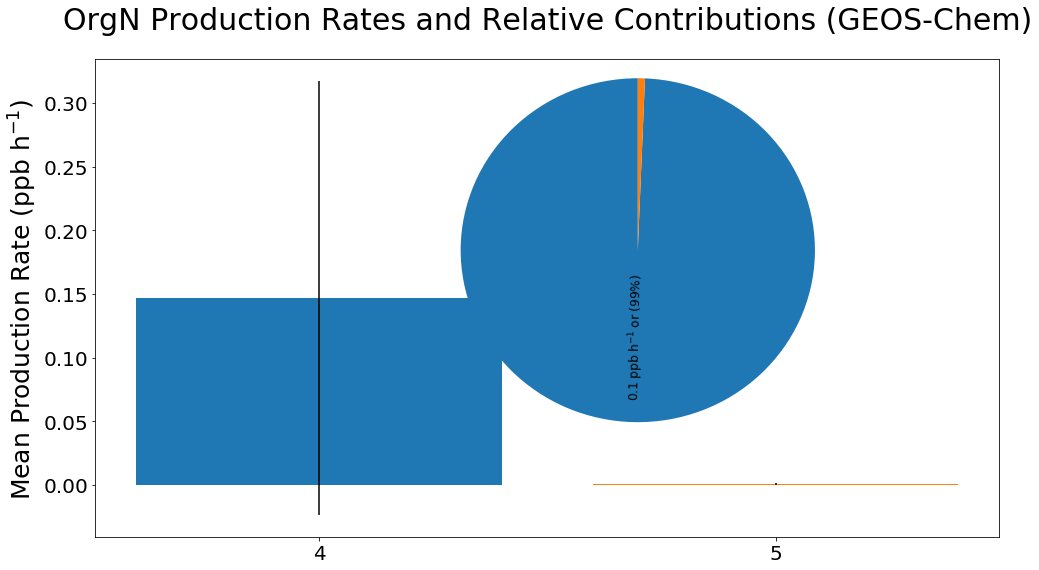

In [45]:

# -----------
# GEOS-Chem
# -----------
# Create a color palette
colors = plt.cm.tab10.colors[:len(combined_df_gc_grouped)]
palette = ListedColormap(colors)

# Create the bar plot
plt.figure(figsize=(15, 8))
ax = plt.subplot(111)

# Convert categorical indices to numeric positions
categories = combined_df_gc_grouped.index
x_positions = np.arange(len(categories))

# Bar plot
bar =  ax.bar(x_positions, combined_df_gc_grouped['Mean (rates)'], yerr=combined_df_gc_grouped['Std (rates)'], color=palette.colors)
# Set title with increased font size
ax.set_title('OrgN Production Rates and Relative Contributions (GEOS-Chem)', fontsize=30)
# Set x-ticks and labels with increased font size
ax.set_xticks(range(len(combined_df_gc_grouped.index)))
ax.set_xticklabels(combined_df_gc_grouped.index)
# Set x and y axis labels with increased font size
#ax.set_xlabel('Reaction', fontsize=14)
ax.set_ylabel('Mean Production Rate (ppb h$^{-1}$)', fontsize=25)
# Optionally, increase the font size of y-tick labels as well
ax.tick_params(axis='both', labelsize=20)

# Disable the grid for the bar plot
ax.grid(False)

# Pie chart parameters
radius = 0.9
pie_ax = ax.inset_axes([0.15, 0.15, radius, radius])  # Adjust position and size

# Create custom labels based on a threshold
labels = []
for comp, percent in zip(combined_df_gc_grouped.index, combined_df_gc_grouped['Mean (freq)']):
    if percent >= 5:  # Custom threshold
        labels.append(f"{combined_df_gc_grouped.at[comp, 'Mean (rates)']:.1f} ppb h$^{{-1}}$ or ({percent:.0f}%)")
    else:
        labels.append(None)  # Hide label for small components

# Create the pie chart
pie_slices, _ = pie_ax.pie(combined_df_gc_grouped['Mean (freq)'], 
                           autopct=None, startangle=90, labels=None)

# Calculate label positions and rotation within each slice
radius = 0.5
for wedge, label_text, comp in zip(pie_slices, labels, combined_df_gc_grouped.index):
    angle = (wedge.theta1 + wedge.theta2) / 2.0
    x = radius * np.cos(np.deg2rad(angle))
    y = radius * np.sin(np.deg2rad(angle))
    
    # Adjust the rotation angle for the label
    rotation_angle = np.degrees(np.arctan2(y, x))
    # Correct the angle so that text is always right-side-up
    if angle > 90 and angle < 270:
        rotation_angle -= 180
    if comp == 'PAN':
        pie_ax.annotate(label_text, (x, y), 
                        ha='center', va='center', 
                        fontsize=15, rotation=rotation_angle)
    else:
        pie_ax.annotate(label_text, (x, y), ha='center', va='center', fontsize=12, rotation=rotation_angle)
        
# Customize the pie chart appearance
pie_ax.set_aspect('equal')  # Make it circular

# Show the plot
plt.tight_layout()
plt.show()

#### PAN

In [ ]:
Flight_IDs   = ['P-3B', 'RF03', 'FN19']
Flight_IDs   = ['P-3B', 'RF03', 'RF07', 'RF09', 'FN19']
Flight_IDs= ['RF03', 'RF07', 'RF09', 'FN19']
interval_X = 30
# Define a continuous colormap
#cmap1 = sns.color_palette("light:r_r", as_cmap=True)
#cmap2 = sns.color_palette("light:b_r", as_cmap=True)
cmap1 = sns.light_palette("red", as_cmap=True)
cmap2 = sns.dark_palette("blue", as_cmap=True)


# Sample the colormap to get distinct colors
topX = 4
colors1 = [cmap1(i) for i in np.linspace(0, 1, topX+1)][::-1]  # Sample 10 distinct colors
colors2 = [cmap2(i) for i in np.linspace(0, 1, topX+1)]  # Sample 10 distinct colors
# Create a custom colormap from the list of colors
colors1 = ListedColormap(colors1)
colors2 = ListedColormap(colors2)
# plotting for the figure
linewidth = 3
error_infor = False
fontsize_flight = 20
fontsize_tick   = 20
fontsize_label  = 12
fontsize_comp   = 18

# colors for model
colors = ['green', 'purple', 'orange', \
          'red', 'blue']

compound, is_nemr = 'PAN', 1


# Initialize an empty DataFrame for all flights
combined_conc_obs        = {}
combined_conc_mod        = {}
combined_prod_rates      = {}
combined_prod_rates_freq = {}

# subplots 
fig, axes = plt.subplots(3, len(Flight_IDs), 
                         figsize=(6*len(Flight_IDs), 4*3),)
                         #sharex='col')
for col, Flight_ID in enumerate(Flight_IDs):
    shaded_uncertainty = name2uncertainty.get(compound, 0.15)
    # auto change for each flight ID
    if Flight_ID in ['RF03', 'RF07', 'RF09']: file_prefix_conc  = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/WE-CAN/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['FN19']: file_prefix_conc = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/FIREX-AQ/Dataprocess/analysis_bycompound/'
    if Flight_ID in ['P-3B']: file_prefix_conc = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/F0AM_analysis_TS/P-3B/Dataprocess/analysis_bycompound/'
    path = Path(file_obs)
    file_prefix_rates = '/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/PL_budget/output/'
    # ------------------------
    # Read concenctration data
    # ------------------------
    # Observation
    # ! Initial CO
    # Read CO smk data
    data_CO_smk_init = pd.read_csv(f'{file_prefix_conc}CO/{Flight_ID}_obs_smk.csv', index_col=0)['Observation'].iloc[0]
    if path.is_file():
        df_compound_obs      = pd.read_csv(f'{file_prefix_conc}{compound}/{Flight_ID}_obs_{postfix}.csv', index_col=0)
        df_compound_obs_nemr = pd.read_csv(f'{file_prefix_conc}{compound}/{Flight_ID}_obs_smk_dil.csv', index_col=0) / data_CO_smk_init
        df_compound_obs.index.name='Avg_physical_age_min'
        df_compound_obs_nemr.index.name='Avg_physical_age_min'
    else:
        df_dummy = pd.read_csv(file_prefix_conc + 'O3' + '/'+ Flight_ID + '_obs_' + postfix +'.csv', index_col=0)
        df_compound_obs      = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
        df_compound_obs_nemr = pd.DataFrame(0, index=df_dummy.index, columns = ['Observation'])
    # Model
    df_compound_mod     = pd.read_csv(f'{file_prefix_conc}{compound}/{Flight_ID}_mod_{postfix}.csv', index_col=0)
    df_compound_mod_nemr= pd.read_csv(f'{file_prefix_conc}{compound}/{Flight_ID}_mod_smk_dil.csv', index_col=0) / data_CO_smk_init
    df_compound_mod.index.name='Avg_physical_age_min'
    df_compound_mod_nemr.index.name='Avg_physical_age_min'

    # -------------------------
    # Read production/loss rate
    # -------------------------
    if compound == 'PAN':
        df_prod_MCO3 = pd.read_csv(f'{file_prefix_rates}CH3CO3/{Flight_ID}_Production_rates_full_MCMBBVOC.csv', index_col=0)
        df_loss_MCO3 = pd.read_csv(f'{file_prefix_rates}CH3CO3/{Flight_ID}_Loss_rates_full_MCMBBVOC.csv', index_col=0)
        df_prod_PAN = pd.read_csv(f'{file_prefix_rates}PAN/{Flight_ID}_Production_rates_full_MCMBBVOC.csv', index_col=0)
        df_loss_PAN = pd.read_csv(f'{file_prefix_rates}PAN/{Flight_ID}_Loss_rates_full_MCMBBVOC.csv', index_col=0)
        # Convert categorical columns to numeric
        df_prod_MCO3 = df_prod_MCO3.apply(pd.to_numeric, errors='coerce')
        # Normalize each row to percentage
        df_prod_MCO3_norm = df_prod_MCO3.div(df_prod_MCO3.sum(axis=1), axis=0)
        # Sacle up the production
        df_prod = df_prod_MCO3_norm.mul(df_prod_PAN['CH3CO3 + NO2'], axis=0)
        df_loss = df_loss_PAN
        
    else:
        df_prod = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Production_rates_full_MCMBBVOC.csv', index_col=0)
        df_loss = pd.read_csv(f'{file_prefix_rates}{compound}/{Flight_ID}_Loss_rates_full_MCMBBVOC.csv', index_col=0)
    
    # Group time
    data_prod = bin_df(df_prod, interval_X)
    data_loss = bin_df(df_loss, interval_X)
   
    # group model data
    df_prod_dummy = data_prod.xs('mean', level=1, axis=1) 
    #df_prod_raw = prd_map_process(df_prod_dummy)
    
    df_prod_raw = df_prod_dummy
    # Rename specific columns
    df_prod_raw = df_prod_raw.rename(columns={
        'BIACET + hv': '2,3-Butanedione + hv',
        'OH + CH3CHO': 'Acetaldehyde + OH',
        'MGLYOX + hv': 'Methylglyoxal + hv',
        'OH + MGLYOX': 'Methylglyoxal + OH',
        'HMVKBO': 'MVK + OH',
    })
    df_prod_raw['Methylglyoxal'] = df_prod_raw['Methylglyoxal + hv'] + df_prod_raw['Methylglyoxal + OH']
    df_prod_raw.drop(['Methylglyoxal + hv', 'Methylglyoxal + OH'], axis=1, inplace=True)
    df_loss_raw = data_loss.xs('mean', level=1, axis=1)
    
    # Select the top X
    df_prod_reduced = get_mean_topX_df(df_prod_raw, topX, ascending=False)
    df_loss_reduced = get_mean_topX_df(df_loss_raw, topX, ascending=True)
    
    df_prod_reduced_freq = (100)*df_prod_reduced.div(df_prod_reduced.sum(axis=1), axis=0)
    df_loss_reduced_freq = (-100)*df_loss_reduced.div(df_loss_reduced.sum(axis=1), axis=0)
    # ------------------------
    # Plotting concentration
    # ------------------------
    # Observation
    if is_nemr:
        df_compound_obs_plot, df_compound_mod_plot = df_compound_obs_nemr*100, df_compound_mod_nemr*100
    else:
        df_compound_obs_plot, df_compound_mod_plot = df_compound_obs, df_compound_mod
    
    if path.is_file() and df_compound_obs_plot['Observation'].values[0] != 0:
        # polinomial regression line
        # train the model based on observation data
        idx = np.isfinite(df_compound_obs_plot.index) & np.isfinite(df_compound_obs_plot['Observation'])         # only pass datapoint with values
        coefs = np.polyfit(df_compound_obs_plot.index[idx], df_compound_obs_plot['Observation'][idx], 2) # 3 may be the best fit
        poly_model = np.poly1d(coefs)
        # plotting scatters
        axes[0, col].scatter(df_compound_obs_plot.index/60, df_compound_obs_plot['Observation'], label = '$Obs$', color = 'black')
    
    # MCM
    axes[0, col].plot(df_compound_mod_plot.index/60.0, df_compound_mod_plot['GEOS-Chem (base)'],\
                        color=colors[0],  label='$GC$', linewidth=linewidth)
    axes[0, col].plot(df_compound_mod_plot.index/60.0, df_compound_mod_plot['MCM + GEOS-Chem VOCs'], \
                        color=colors[4],  label='$MCM_{GCVOC}$', linewidth=linewidth)  
    axes[0, col].plot(df_compound_mod_plot.index/60.0, df_compound_mod_plot['MCM + FUR'], \
                        color=colors[3],  label='$MCM_{BBVOC}$', linewidth=linewidth) 
    # ------------
    # Plot the bar
    # ------------
    # Plot the bar plots using the reset index as the x-axis
    prod_bar = df_prod_reduced.plot.bar(ax=axes[1, col], stacked=True, colormap=colors1,
                                              edgecolor='black', linestyle="-", width=0.7)
    loss_bar = df_loss_reduced.plot.bar(ax=axes[1, col], stacked=True, colormap=colors2,
                                              edgecolor='black', linestyle="-", width=0.7)
    
    prod_freq_bar = df_prod_reduced_freq.plot.bar(ax=axes[2, col], stacked=True, colormap=colors1,
                                              edgecolor='black', linestyle="-", width=0.7)
    loss_freq_bar = df_loss_reduced_freq.plot.bar(ax=axes[2, col], stacked=True, colormap=colors2,
                                              edgecolor='black', linestyle="-", width=0.7)

    # --------------
    # Plot setttings
    # --------------
    # Set up the title
    axes[0, col].set_title(id2fire_name[Flight_ID], loc ='center', size=fontsize_flight)
    
    # Font size
    axes[0, col].tick_params(axis='both', labelsize=fontsize_tick)
    axes[1, col].tick_params(axis='both', labelsize=fontsize_tick)
    axes[2, col].tick_params(axis='both', labelsize=fontsize_tick)

    # X axis setting
    # !Second row and third
    # Get the current x-tick labels and convert them to integers
    labels = ['{:.1f}'.format(float(item.get_text())/60) for item in axes[1, col].get_xticklabels()]
    #axes[1, col].set_xticklabels(labels,rotation=30,)
    axes[2, col].set_xticklabels(labels,rotation=30,)
        
    # !First row
    x_range = [float(label) for label in labels]
    axes[0, col].set_xticks(x_range)  # Set the positions for the ticks
    axes[0, col].set_xticklabels([f'{x:.1f}' for x in x_range], rotation=30)  # Set the labels for the ticks
    
    # Optional: If you want to set a limit for the x-axis
    axes[0, col].set_xlim([min(x_range), max(x_range)])
    # Mute the x ticks
    axes[0, col].set_xticklabels([])  # Hides x-axis tick labels for the first row
    axes[1, col].set_xticklabels([])  # Hides x-axis tick labels for the first row
    # Mute the xlables for some columns
    median_num = int(np.median(list(range(0, len(Flight_IDs)))))
    if col != median_num: 
        axes[-1, col].xaxis.label.set_visible(False)
    else:
        axes[-1, col].set_xlabel('Plume age (hour)', fontsize=fontsize_comp*1.5)
        
    # set up the legend
    font = font_manager.FontProperties(size=fontsize_label*1.2, weight='semibold')
    # edit part
    handles, labels= reorderLegend(axes[0, col],['$Observation$', 
                                                 #'$Obs, fitted$', \
                                                '$GC$', '$MCM_{GCVOC}$', '$MCM_{BBVOC}$'])
    axes[0, col].legend(loc="upper right", prop=font, handles= handles, labels=labels)
    axes[1, col].legend(fontsize=fontsize_label*1.2, loc='upper right')
    # Mute the legend for the third row
    axes[2, col].legend().set_visible(False)
    
    # edit part, uncomment when we compare MCM+Furan and MCM, with CTM VOCs
    # get the range for the x/y axis
    xmin, xmax = axes[0, col].get_xlim()
    ymin, ymax = axes[0, col].get_ylim()
    
    # -----------------
    # Model evaluations
    # -----------------
    if path.is_file() and df_compound_obs['Observation'].values[0] != 0:
        abs_diff_gc, relative_diff_gc = evaluate_model_differences(df_compound_obs_plot, df_compound_mod_plot['GEOS-Chem (base)'], poly_model, 'GEOS-Chem (base)', compound)
        abs_diff_mcm_gcvoc, relative_diff_mcm_gcvoc = evaluate_model_differences(df_compound_obs_plot, df_compound_mod_plot['MCM + GEOS-Chem VOCs'], poly_model, 'MCM + GEOS-Chem VOCs', compound)
        abs_diff_mcm_fur, relative_diff_mcm_fur = evaluate_model_differences(df_compound_obs_plot, df_compound_mod_plot['MCM + FUR'], poly_model, 'MCM + FUR', compound)

        diff_str_gc        = '{:.0f}'.format(abs_diff_gc) + 'ppb (' + '{:.0f}'.format(relative_diff_gc) +'%)'
        diff_str_mcm_gcvoc = '{:.0f}'.format(abs_diff_mcm_gcvoc) + 'ppb (' + '{:.0f}'.format(relative_diff_mcm_gcvoc) +'%)'
        diff_mcm_fur       = '{:.0f}'.format(abs_diff_mcm_fur) + 'ppb (' + '{:.0f}'.format(relative_diff_mcm_fur) +'%)'
        if compound in Comps_in_GC:
            axes[0, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.32+ymin, diff_str_gc, fontsize=fontsize_tick, color = colors[0])  
            axes[0, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.22+ymin, diff_str_mcm_gcvoc, fontsize=fontsize_tick, color = colors[4])  
        axes[0, col].text((xmax-xmin)*0.05+xmin, (ymax-ymin)*0.12+ymin, diff_mcm_fur, fontsize=fontsize_tick, color = colors[3])


    # Compare MCM with GEOS-Chem VOCs to GEOS-Chem (base)
    abs_diff_mcm_gc, relative_diff_mcm_gc = model_vs_model_evaluation(
        df_compound_mod_plot['MCM + GEOS-Chem VOCs'],
        df_compound_mod_plot['GEOS-Chem (base)'],
        'MCM + GEOS-Chem VOCs',
        'GEOS-Chem (base)',
        compound
    )

    # Compare MCM with FUR to GEOS-Chem (base)
    abs_diff_mcm_fur_gc, relative_diff_mcm_fur_gc = model_vs_model_evaluation(
        df_compound_mod_plot['MCM + FUR'],
        df_compound_mod_plot['GEOS-Chem (base)'],
        'MCM + FUR',
        'GEOS-Chem (base)',
        compound
    )

    # Optionally, you could also compare MCM with FUR to MCM with GEOS-Chem VOCs
    abs_diff_mcm_fur_gcvoc, relative_diff_mcm_fur_gcvoc = model_vs_model_evaluation(
        df_compound_mod_plot['MCM + FUR'],
        df_compound_mod_plot['MCM + GEOS-Chem VOCs'],
        'MCM + FUR',
        'MCM + GEOS-Chem VOCs',
        compound
    )
    # Save out the produciton
    combined_conc_mod[Flight_ID]        = df_compound_mod_plot.mean(axis=0)
    combined_conc_obs[Flight_ID]        = df_compound_obs_plot.mean(axis=0)
    combined_prod_rates[Flight_ID]      = df_prod_reduced.mean(axis=0)
    combined_prod_rates_freq[Flight_ID] = df_prod_reduced_freq.mean(axis=0)

# Add y-axis labels for each row
if is_nemr:   
    axes[0, 0].set_ylabel('∆PAN/∆CO (%)', fontsize=fontsize_comp)
else:
    axes[0, 0].set_ylabel('Dilution-corrected mxr (ppb)', fontsize=fontsize_comp)

axes[1, 0].set_ylabel('P/L rates (ppb h$^{-1}$)', fontsize=fontsize_comp)
axes[2, 0].set_ylabel('Normalized rates (%)', fontsize=fontsize_comp)

# Add the main title to the figure
plt.text(x=0.5, y=0.95, s="∆PAN/∆CO, production, and loss rates in plumes", fontsize=28,  ha='center', va='center', transform=fig.transFigure,) #fontweight='bold',)

plt.subplots_adjust(wspace=.20, hspace=.05)
fig.align_ylabels(axes[:, 0])  # Align y-labels for the first column of each row

fig.savefig("/glade/work/lixujin/PYTHON/SciProj/Box_modeling_analysis/OrganicNitrates/figures/output_filename.jpg", format='jpg')
plt.show()

In [ ]:
'''
# Convert your dictionary to a DataFrame, and drop columns where all values are zero
df_conc_obs = pd.DataFrame(combined_conc_obs)
df_conc_obs = df_conc_obs.loc[:, (df_conc_obs != 0).any(axis=0)]

df_rates    = pd.DataFrame(combined_prod_rates)
df_freq     = pd.DataFrame(combined_prod_rates_freq)

# Calculate mean and standard deviation for each reaction
mean_conc   = df_conc_obs.mean(axis=1)
std_conc   = df_conc_obs.std(axis=1)

mean_values = df_rates.mean(axis=1)
std_values  = df_rates.std(axis=1)
mean_freq = df_freq.mean(axis=1)
std_freq  = df_freq.std(axis=1)

# Combine mean and std into a single DataFrame
combined_stats_rates = pd.DataFrame({'Mean': mean_values, 'Std': std_values})
combined_stats_freq = pd.DataFrame({'Mean': mean_freq, 'Std': std_freq})

# Sort the DataFrame by the 'Mean' column in descending order
combined_stats_rates = combined_stats_rates.sort_values(by='Mean', ascending=False)
combined_stats_freq  = combined_stats_freq.sort_values(by='Mean', ascending=False)

print(combined_stats_rates)
print(combined_stats_freq)
print(mean_conc, std_conc)
'''
